# Import libraries

In [2]:
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype

# Read Datasets

In [37]:
la_trees_fire_unique_grouped = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_unique_grouped.csv")
la_trees_fire_temp = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_temp.csv")

# Visualized the tree density in LA

In [38]:
la_trees_fire_temp.shape

(51896, 24)

In [ ]:
la_trees_fire_temp.columns

Index(['Latitude', 'Longitude', 'Species', 'DBH', 'Any_Protected', 'tree_id',
       'geometry', 'index_right', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY',
       'UNIT_ID', 'FIRE_NAME', 'CAUSE', 'GIS_ACRES', 'DECADES', 'Shape__Area',
       'Shape__Length', 'tree_appear_count', 'FIRE_SIZE_CATEGORY',
       'USDA_FIRE_SIZE_CLASS', 'TreeGroup'],
      dtype='object')

In [41]:
drop_columns = ['tree_id', 'geometry', 'FIRE_NAME', 'index_right', 'UNIT_ID', 'DECADES', 'USDA_FIRE_SIZE_CLASS','Species', 'GIS_ACRES','Shape__Area', 'Shape__Length','STATE', "AGENCY", "Any_Protected"]
la_trees_fire_model = la_trees_fire_temp.drop(columns=drop_columns)

In [42]:
la_trees_fire_model

,Latitude,Longitude,DBH,OBJECTID,YEAR_,CAUSE,tree_appear_count,FIRE_SIZE_CATEGORY,TreeGroup,Annual_Temp
0,34.154814,-118.589896,25.0,18164,1944.0,14,1,Large,Oak,62.2
1,34.154815,-118.589929,13.0,18164,1944.0,14,1,Large,Oak,62.2
2,34.275480,-118.541392,0.0,15798,1959.0,14,2,Medium,Myla311,67.3
3,34.145944,-118.505713,0.0,15674,1960.0,14,1,Small,Myla311,65.6
4,34.089382,-118.452487,10.0,15426,1961.0,14,1,Large,Oak,65.3
...,...,...,...,...,...,...,...,...,...,...
51891,34.281985,-118.524873,1.0,17827,1947.0,14,1,Medium,Eucalyptus,64.1
51892,34.281909,-118.524855,1.0,17827,1947.0,14,1,Medium,Oak,64.1
51893,34.281829,-118.524832,1.0,17827,1947.0,14,1,Medium,Oak,64.1
51894,34.281753,-118.524804,1.0,17827,1947.0,14,1,Medium,Oak,64.1


# Model - Random Forest

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Define features and target
X = la_trees_fire_model[['Latitude', 'Longitude', 'DBH', 'YEAR_', 'CAUSE', 'tree_appear_count', 'TreeGroup']]
y = la_trees_fire_model['FIRE_SIZE_CATEGORY']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_encoded)

# Preprocessing for numeric and categorical features
numeric_features = ['Latitude', 'Longitude', 'DBH', 'YEAR_', 'tree_appear_count']
categorical_features = ['CAUSE', 'TreeGroup']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Create a pipeline with a Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       Large       1.00      1.00      1.00      1917
      Medium       1.00      1.00      1.00      4073
       Small       1.00      0.98      0.99       910
  Very Large       1.00      1.00      1.00      3480

    accuracy                           1.00     10380
   macro avg       1.00      0.99      1.00     10380
weighted avg       1.00      1.00      1.00     10380



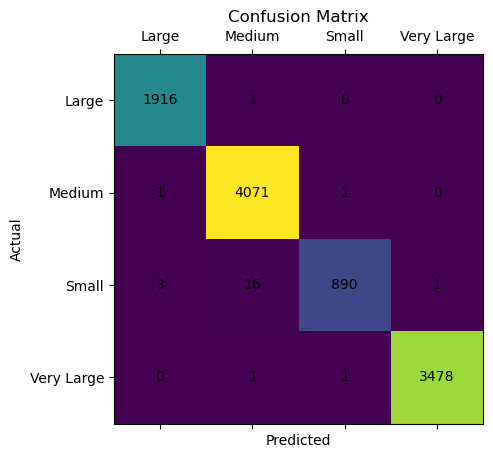

In [45]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(len(le.classes_)))
ax.set_yticks(range(len(le.classes_)))
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center')
plt.show()

In [46]:
import numpy as np

feature_names_num = numeric_features
feature_names_cat = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [47]:
feat_imp.iloc[0:20]

,feature,importance
1,Longitude,0.302400
3,YEAR_,0.263107
0,Latitude,0.213250
4,tree_appear_count,0.042116
8,CAUSE_11,0.041158
5,CAUSE_3,0.027124
9,CAUSE_14,0.024654
2,DBH,0.019009
70,TreeGroup_Oak,0.006335
44,TreeGroup_Eucalyptus,0.005642


# Model - XGBoost

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Define features and target
X = la_trees_fire_model[['Latitude', 'Longitude', 'DBH', 'YEAR_', 'CAUSE', 'tree_appear_count', 'TreeGroup']]
y = la_trees_fire_model['FIRE_SIZE_CATEGORY']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Preprocessing steps
numeric_features = ['Latitude', 'Longitude', 'DBH', 'YEAR_', 'tree_appear_count']
categorical_features = ['CAUSE', 'TreeGroup']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Create a pipeline with a Gradient Boosting classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the boosting model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Extract feature importances
import numpy as np

feature_names_num = numeric_features
feature_names_cat = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


Classification Report:
              precision    recall  f1-score   support

       Large       0.99      0.99      0.99      1917
      Medium       0.99      1.00      0.99      4073
       Small       0.99      0.94      0.97       910
  Very Large       0.99      1.00      1.00      3480

    accuracy                           0.99     10380
   macro avg       0.99      0.98      0.99     10380
weighted avg       0.99      0.99      0.99     10380



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(len(le.classes_)))
ax.set_yticks(range(len(le.classes_)))
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center')
plt.show()

In [49]:
feat_imp.iloc[0:20]

,feature,importance
1,Longitude,0.429368
3,YEAR_,0.348238
0,Latitude,0.186035
5,CAUSE_3,0.011334
7,CAUSE_7,0.008449
4,tree_appear_count,0.006846
8,CAUSE_11,0.004503
6,CAUSE_4,0.001807
14,TreeGroup_Ailanthus,0.000583
9,CAUSE_14,0.000564
